# First Steps: CAM
- resnet 50 has already the right structure with conv - GAP - dense
- otherwise we need to retrain the network with this structure
- for general application without retraining use gradCAM

In [1]:
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from scipy.ndimage import zoom
input_path = "C:/DL_Lab/Racoon_dataset/train/raccoon-20_jpg.rf.fb19aa368c074a61eed8829617ed6b7c.jpg"

(-0.5, 223.5, 223.5, -0.5)

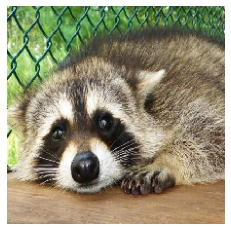

In [2]:
# load and import image with keras in RGB format
orig_image = load_img(input_path, target_size=(224,224))
image = img_to_array(orig_image) # scales to 0-255
image = preprocess_input(image)
image = np.expand_dims(image, axis=0)
plt.imshow(orig_image)
plt.axis("off")

In [3]:
# pretrained model
model = ResNet50(input_shape=(224,224,3), include_top=True, weights="imagenet")

In [4]:
# get model prediction
preds = model.predict(image)
pred_name = decode_predictions(preds, top=1)[0][0][1]
pred_index = np.argmax(preds[0])

In [5]:
# get model that ends with last conv layer
last_conv_layer = model.get_layer("conv5_block3_out")
convModel = Model(inputs=model.input, outputs=last_conv_layer.output)
fmaps = convModel.predict(image)[0]
fmaps.shape

(7, 7, 2048)

In [6]:
# get weights of last dense layer to weight the feature maps 
last_dense = model.get_layer("predictions")
fmap_weights = last_dense.get_weights()[0] # weights, [1] would be bias
fmap_weights.shape # 2048 feature maps and 1000 classes

(2048, 1000)

In [7]:
# 2048 weights (one per fmap) of winner class
class_fmap_weights = fmap_weights[:,pred_index]
# 7x7 cam image = w1 * f1 + w2 * f2 + ... weighted addition of fmaps
cam = fmaps.dot(class_fmap_weights)
cam.shape

(7, 7)

In [8]:
# upsample cam to original image size 224x224 (32 times)
ups_cam = zoom(cam, (32,32), order=1)
# scale cam to [0,1]
min = tf.math.reduce_min(ups_cam)
max = tf.math.reduce_max(ups_cam)
ups_cam = (ups_cam - min) / (max - min)

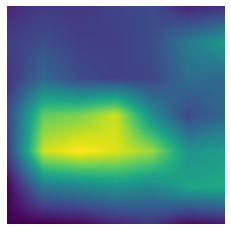

In [9]:
plt.imshow(ups_cam, cmap="viridis")
plt.axis("off")

(-0.5, 223.5, 223.5, -0.5)

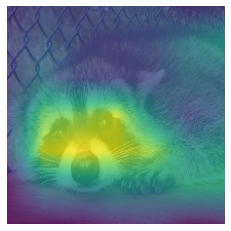

In [10]:
plt.imshow(orig_image, alpha=1)
plt.imshow(ups_cam, cmap="viridis", alpha=0.8)
plt.axis("off")